# [LG 에너지 솔루션]
## DX Expert 양성과정 WEEK 2
## Transformer - (3) 시계열 데이터 실습



## 강의 복습

강의자료 : Transformer, AGENDA 03 - Transformer for Time-Series Data

## 실습 요약
1. 본 실습에서는 Transformer 기반의 이상치 탐지 모델인 STOC를 활용하여 시계열 이상탐지 모델을 구축합니다
2. 학습된 모델을 활용하여 평가를 진행합니다
3. 해당 모델에 대한 전체적인 구조는 강의자료 AGENDA 03 116 page에서 확인하실 수 있습니다

----

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [1]:
# github에서 데이터 불러오기
!git clone https://github.com/yukyunglee/LG_ES_Transformer

Cloning into 'LG_ES_Transformer'...
remote: Enumerating objects: 487, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 487 (delta 31), reused 55 (delta 22), pack-reused 420
Receiving objects: 100% (487/487), 1.81 GiB | 23.33 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [1]:
import os
import sys
import json
import time
import random
import importlib
import numpy as np
import pandas as pd
from easydict import EasyDict
import matplotlib.pyplot as plt

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn

from sklearn.metrics import roc_auc_score, precision_recall_curve

# from trainer import Trainer
from LG_ES_Transformer.STOC.dataloader import make_matplt, get_dataloader

import warnings
warnings.filterwarnings("ignore")

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.7.0 (default, Oct  9 2018, 10:31:47) 
[GCC 7.3.0]].
PyTorch version:[1.6.0].
device:[cuda:0].


In [2]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기

금일 실습에서는 Yahoo S5 데이터를 활용하여 시계열 이상치 탐지를 진행합니다.
* 해당 데이터는 연구용 시계열 데이터로 실제 데이터가 아닌 합성 데이터들로 이루어짐
* 여러가지 데이터중 한가지 시계열 데이터를 가져와 학습 및 추론을 수행함
* 데이터셋 출처
    * https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70

In [3]:
# 현재 데이터는 확인 용도

data = pd.read_csv('./LG_ES_Transformer/data/yahoo_S5/A2Benchmark/synthetic_1.csv')

In [4]:
# 데이터 분석 
def make_df_matplt(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(30, 5))

    # ax.set_title(data_name)
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    ax.plot(df.timestamp, df.value)
    for i, label in enumerate(df.is_anomaly):
        if label == 1:
           ax.axvline(x=df.timestamp[i], linewidth=0.5, color='#d62728')
    plt.show()

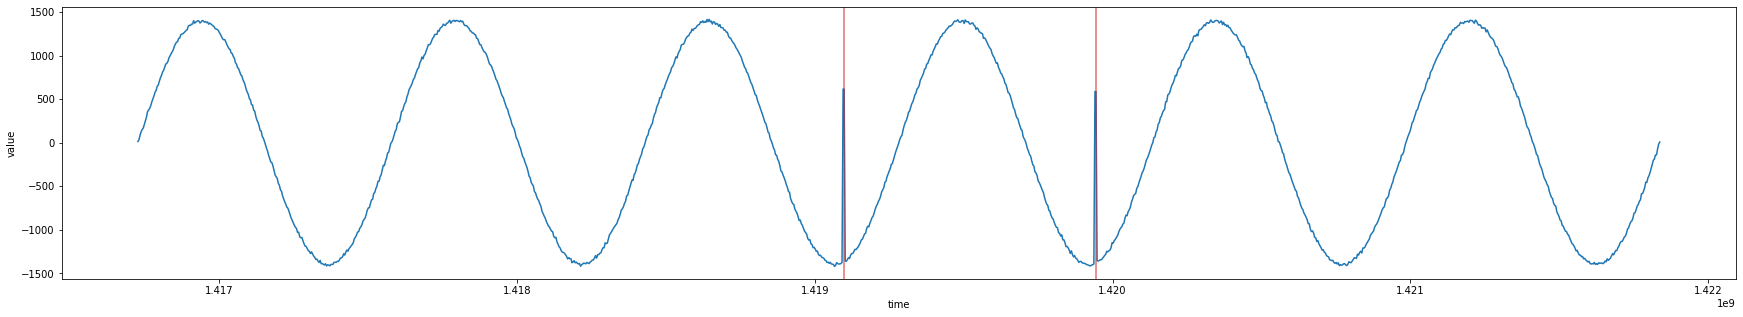

In [5]:
make_df_matplt(data)

### STEP 2. 학습과정 모듈화 이해하기 
* 앞선 실습과 달리 모든 학습 코드는 모듈화 되어있습니다
* 모듈화 된 코드들도 데이터 전처리 - DataSet - DataLoader 과정을 거쳐 데이터를 생성합니다
* 만들어진 데이터들은 동일하게 모델 학습에 사용됩니다


#### Trainer 이해하기
* 학습하는 모든 과정은 어떤 모델, 어떤 구조를 사용하더라도 항상 반복됩니다
* 반복되는 과정은 하나의 파이프라인으로 구성할 수 있으며, 대부분의 개발자와 연구자들은 아래와 같이 Trainer를 만들어 학습을 진행합니다
* 모든 딥러닝 모델은 데이터를 생성하고 - 모델을 정의하고 - 반복학습(epoch)을 통해 여러번 학습되므로 모든 과정은 구조화 되어있음을 알 수 있습니다

In [6]:
class Trainer:
    """
    Required:
        Functions for
                train
                valid
                test
    Outputs:
        best_checkpoint
        prediction and anomaly score plot
    """

    # anomaly score, model 정의
    def __init__(
        self,
        args,
        full_len,
        trn_len,
        dev_len,
        tst_len,
        full_loader,
        trn_loader,
        dev_loader,
        tst_loader,
    ):
        """
        arg: config.py에서 설정한 arguments
        trn_loader, dev_loader, tst_loader: get_datalaoder로 생성한 dataset
        data_path: root_path 폴더 안에 있는 arg.data_name 데이터의 path
        """

        self.args = args
        self.full_loader = full_loader
        self.trn_loader = trn_loader
        self.dev_loader = dev_loader
        self.tst_loader = tst_loader

        self.full_len = full_len
        self.trn_len = trn_len
        self.dev_len = dev_len
        self.tst_len = tst_len

        self.data_path = self.args.root_path + self.args.data_name

        # GPU 설정
        self.device = torch.device(
            "cuda" if self.args.cuda else "cpu"
        )  # select the device

    def fit(self):
        '''
        학습 MAIN 함수
        '''

        # 학습 후, model의 checkpoint 저장 경로
        self.path = f"./saved_model/{self.args.experiment_name}/{self.data_path[3:-4]}/"
        os.makedirs(self.path, exist_ok=True)

        # 새로 학습할 때, (args.training == True)
        if self.args.training:
            print("training...")
            # N번째 training 할 때, version_N 폴더 생성하여 model checkpoint 저장
            self.version = 0
            while True:
                self.save_path = os.path.join(self.path, f"version-{self.version}")
                if not os.path.exists(self.save_path):
                    os.makedirs(self.save_path)
                    break
                else:
                    self.version += 1

            # save arguments
            with open(f"{self.save_path}/arguments.txt", "w") as f:
                json.dump(self.args.__dict__, f, indent=2)

            # 초기 validation loss 설정
            # validation loss가 min_loss보다 작을 때, model checkpoint 저장
            min_loss = 10e15

            # validation loss가 이전 iteration 보다 작으면 best에 현재 iteration 저장
            # 0으로 초기화
            best = 0

            '''
            STEP 1) MODEL 정의하기
            '''
            # model 초기화
            model, optimizer, scheduler, criterion = self.init_model()
            losses = []

            # for early stopping
            self.trigger_times = 0
            self.early_stopped = False

            '''
            STEP 2) 여러번 EPOCH을 통해 학습 진행하기
            '''
            for epoch in range(self.args.epochs):
                # 한 epoch 돌 때마다, 현재의 best와 min_loss 받음
                epoch_loss = 0
                print(epoch)

                '''
                STEP 3) 한번의 EPOCH에서 수행되는 학습 과정
                '''
                best, min_loss, model, epoch_loss = self._train_epoch(
                    epoch,
                    min_loss,
                    best,
                    model,
                    criterion,
                    optimizer,
                    scheduler,
                    epoch_loss,
                )

                losses.append(epoch_loss)
                print("-" * 89)
                print(
                    "| end of epoch {:3d} | epoch loss {:5.8f}".format(
                        epoch + 1, epoch_loss
                    )
                )
                print("=" * 89)

                if self.early_stopped:
                    break

            # plotting train loss
            fig, ax = plt.subplots(figsize=(20, 5))
            ax.plot(losses)
            ax.set_title("Training")
            ax.set_xlabel("epoch")
            ax.set_ylabel("loss")
            plt.ylim(0, 1)
            # plt.show()
            fig.savefig(f"{self.save_path}/loss.png")
            plt.close()

            # train/valid/test plotting
            if self.args.normal:
                data = pd.read_csv(
                    self.args.root_path
                    + f"normalized_{self.args.data_name[:-4]}_val_{self.args.valid_ratio}_tst_{self.args.test_ratio}.csv"
                )
            else:
                data = pd.read_csv(self.data_path)

            make_matplt(
                data, self.args.data_name, self.trn_len, self.tst_len, self.save_path
            )

        # 학습된 model을 불러와서 test만 할 때,
        # 지정한 version 폴더 안의 best iteration 찾기
        else:
            # test에 쓸 version을 지정
            self.version = self.args.version

            if self.args.checkpoint == "best":
                # version 폴더 안에서 가장 마지막 best iteration 찾기
                best = 1
                for _, _, files in os.walk(
                    f"{self.path}version-{self.version}/checkpoints/"
                ):
                    # 가장 마지막으로 update된 best itebest_resultration 찾기
                    for f in files:
                        if "pt" in f:
                            num = f.split("-")[1][:-3]
                            if int(num) >= best:
                                best = int(num)
            else:
                best = int(self.args.checkpoint.split("-")[1])

            self.save_path = f"{self.path}version-{self.version}/result/{best}"

        return best, self.version

    # model 및 optimiaer, scheduler 선언
    def init_model(self):
        module = importlib.import_module(f"LG_ES_Transformer.STOC.models.{self.args.model}")
        model = module.Model(self.args).to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.args.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=100, eta_min=0.00001
        )
        criterion = nn.MSELoss()

        os.makedirs(f"{self.save_path}/training_info/", exist_ok=True)

        with open(f"{self.save_path}/training_info/information.txt", "w") as f:
            print("[Model architecture] \n", model, file=f)
            print("[Optimizer] \n", optimizer, file=f)
            print("[Scheduler] \n", scheduler, file=f)
            print("[Criterion] \n", criterion, file=f)

        return model, optimizer, scheduler, criterion

    def _train_epoch(
        self, epoch, min_loss, best, model, criterion, optimizer, scheduler, epoch_loss
    ):
        model.train()

        start_time = time.time()
        aug = torch.arange(-3, 3.1, 0.5)
        for batch, (x, targets) in enumerate(self.trn_loader):

            x = torch.unsqueeze(x, 2).to(self.device)  # batch, seq_len, feature
            targets = torch.unsqueeze(targets, 2).to(
                self.device
            )  # batch, seq_len, feature

            optimizer.zero_grad()
            output = model(x)  # batch, seq_len, feature
            loss = criterion(output, targets)
            loss.backward()

            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()

            if self.args.trend_learning:
                print("augmentation")
                for aug_value in aug:
                    x_tmp = torch.add(x, aug_value)
                    targets_tmp = torch.add(targets, aug_value)
                    optimizer.zero_grad()
                    output_tmp = model(x_tmp)
                    loss = criterion(output_tmp, targets_tmp)
                    loss.backward()

                    optimizer.step()
                    scheduler.step()

            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:4d}/{:4d} batches | "
                "lr {:02.6f} | {:5.2f} s | "
                "loss {:5.5f} ".format(
                    epoch + 1,
                    batch + 1,
                    self.trn_len // self.args.batch_size,
                    scheduler.get_lr()[0],
                    elapsed,
                    loss.item(),
                )
            )
            start_time = time.time()

        # validation set의 total loss 계산
        val_loss = self.evaluate(
            model, self.dev_loader, criterion, None, eval_plot=False
        )

        print("-" * 89)
        print("| end of epoch {:3d} | valid loss {:5.2f}".format(epoch + 1, val_loss))
        print("-" * 89)

        # 현재 epoch loss가 직전까지의 min_loss보다 작으면,
        # model 저장하고, min_loss를 현재 epoch loss로 updatec
        # Add early stopping
        if self.args.early_stopping:
            if val_loss >= min_loss:
                self.trigger_times += 1
                print("trigger times:", self.trigger_times)
                if self.trigger_times >= self.args.patience:
                    self.early_stopped = True
                    print(
                        f"Early stopping at {epoch + 1}. Best model is at {best} epoch"
                    )
                    return best, min_loss, model, epoch_loss

            elif val_loss < min_loss and epoch >= self.args.min_epoch:
                self.trigger_times = 0

                print("-" * 89)
                print(f"save best model in {self.save_path}/checkpoints")
                print("-" * 89)

                os.makedirs(f"{self.save_path}/checkpoints", exist_ok=True)
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": loss,
                    },
                    self.save_path + f"/checkpoints/epoch-{epoch + 1}.pt",
                )

                min_loss = val_loss
                best = epoch + 1

        else:
            if val_loss < min_loss and epoch > self.args.min_epoch:
                print("-" * 89)
                print(f"save best model in {self.save_path}/checkpoints")
                print("-" * 89)

                os.makedirs(f"{self.save_path}/checkpoints", exist_ok=True)
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": loss,
                    },
                    self.save_path + f"/checkpoints/epoch-{epoch + 1}.pt",
                )

                min_loss = val_loss
                best = epoch + 1

            if self.args.save_last and (epoch + 1) == self.args.epochs:
                print("-" * 89)
                print(f"save best model in {self.save_path}/checkpoints")
                print("-" * 89)
                os.makedirs(f"{self.save_path}/checkpoints", exist_ok=True)

                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "loss": loss,
                    },
                    self.save_path + f"/checkpoints/epoch-{epoch + 1}.pt",
                )

                min_loss = val_loss
                best = epoch + 1

        return best, min_loss, model, epoch_loss

    '''
    STEP 4) 학습한 모델을 활용하여 모델 평가하기
    '''
    # evaluate for validation and test
    def evaluate(self, eval_model, dataloader, criterion, result_path, eval_plot=False):
        eval_model.eval()

        total_loss = 0.0
        test_result = torch.Tensor(0)
        truth = torch.Tensor(0)
        anomaly_score = torch.Tensor(0)

        with torch.no_grad():
            for batch, (x, targets) in enumerate(dataloader):
                x = torch.unsqueeze(x, 2).to(self.device)
                targets = torch.unsqueeze(targets, 2).to(self.device)

                output = eval_model(x)
                total_loss += criterion(output, targets).item()

                if batch == 0:
                    test_result = torch.cat(
                        (
                            test_result,
                            output.reshape(-1, self.args.window_size)[0].cpu(),
                            output.reshape(-1, self.args.window_size)[1:, -1].cpu(),
                        ),
                        0,
                    )
                    truth = torch.cat(
                        (
                            truth,
                            targets.reshape(-1, self.args.window_size)[0].cpu(),
                            targets.reshape(-1, self.args.window_size)[1:, -1].cpu(),
                        ),
                        0,
                    )

                else:
                    test_result = torch.cat(
                        (
                            test_result,
                            output.reshape(-1, self.args.window_size)[:, -1].cpu(),
                        ),
                        0,
                    )
                    truth = torch.cat(
                        (
                            truth,
                            targets.reshape(-1, self.args.window_size)[:, -1].cpu(),
                        ),
                        0,
                    )

            anomaly_score = torch.cat(
                (anomaly_score, torch.abs(torch.sub(test_result, truth))), 0
            )

        if eval_plot:
            '''
            OPTION ) 예측 결과 확인을 위해 다양한 그래프 생성하기
            '''
            fig, ax = plt.subplots(figsize=(20, 5))

            ax.plot(truth, color="#1f77b4", label="true", alpha=1)
            ax.plot(
                test_result, color="#ff7f0e", label="predicted", alpha=1, linestyle="-"
            )

            if dataloader == self.full_loader:
                title = "full"
            elif dataloader == self.trn_loader:
                title = "train_set"
            elif dataloader == self.dev_loader:
                title = "valid_set"
            else:
                title = "test_set"

            ax.set_title(
                f"[{self.args.data_name[:-4]}]: Prediction {title} (PATH: {self.args.root_path})"
            )
            ax.set_xlabel("time")
            plt.legend()
            plt.axhline(y=0, color="k")
            plt.savefig(f"{result_path}/{title}_plot.png")
            plt.close()

            # measure performence
            if dataloader == self.full_loader:
                title = "full"

                if self.args.normal:
                    data = pd.read_csv(
                        self.args.root_path
                        + f"normalized_{self.args.data_name[:-4]}_val_{self.args.valid_ratio}_tst_{self.args.test_ratio}.csv"
                    )
                else:
                    data = pd.read_csv(self.data_path)

                data = data.iloc[
                    self.args.forecast_step : len(pd.DataFrame(anomaly_score))
                    + self.args.forecast_step,
                    :,
                ]
                auroc, best_threshold, best_f1 = self.performance_measure(
                    data.is_anomaly.astype(int)[-self.tst_len :],
                    pd.DataFrame(anomaly_score).iloc[-self.tst_len :, :],
                )
                results = pd.DataFrame(
                    {
                        "timestamp": data.timestamp,
                        "value": data.value,
                        "is_anomaly": data.is_anomaly.astype(int),
                        "truth": truth,
                        "test_result": test_result,
                        "anomaly_score": anomaly_score,
                    }
                )
                results.to_csv(f"{result_path}/results.csv")

                fig, ax = plt.subplots(figsize=(20, 5))
                ax.plot(results.truth, color="#1f77b4", label="true", alpha=1)
                ax.plot(
                    results.test_result,
                    color="#ff7f0e",
                    label="predicted",
                    alpha=1,
                    linestyle="-",
                )
                ymin, ymax = ax.get_ylim()
                ax.set_ylim(ymin, ymax)
                ax.vlines(
                    list(results.index[results.is_anomaly == 1]),
                    ymin=ymin,
                    ymax=ymax,
                    color="#d62728",
                    alpha=0.3,
                    label="true anomaly",
                )
                ax.axvspan(
                    len(results) - self.tst_len,
                    results.index[-1],
                    facecolor="green",
                    alpha=0.1,
                    label="TEST SET",
                )
                ax.set_title(
                    f"[{self.args.data_name[:-4]}] Prediction (AUROC: {auroc}, Best F1-score: {best_f1} at threshold:{best_threshold}, PATH: {self.args.root_path})"
                )
                ax.set_xlabel("time")
                plt.legend()
                plt.axhline(y=0, color="k")
                plt.savefig(f"{result_path}/{title}_plot.png")
                plt.close()

                if self.args.anomaly_plot:
                    fig, ax = plt.subplots(figsize=(20, 5))

                    ax.plot(results.anomaly_score, color="k", label="anomaly score")
                    ymin, ymax = ax.get_ylim()
                    ax.set_ylim(ymin, ymax)
                    ax.vlines(
                        list(results.index[results.is_anomaly == 1]),
                        ymin=ymin,
                        ymax=ymax,
                        color="#d62728",
                        alpha=0.6,
                        label="true anomaly",
                    )
                    ax.axhline(
                        best_threshold,
                        color="navy",
                        linestyle="--",
                        alpha=0.8,
                        label="threshold",
                    )
                    ax.axvspan(
                        len(results) - self.tst_len,
                        results.index[-1],
                        facecolor="green",
                        alpha=0.1,
                        label="TEST SET",
                    )

                    tp = list(
                        results.index[
                            (results.anomaly_score >= best_threshold)
                            & (results.is_anomaly == True)
                        ]
                    )
                    fn = list(
                        results.index[
                            (results.anomaly_score < best_threshold)
                            & (results.is_anomaly == True)
                        ]
                    )
                    ax.plot(
                        tp,
                        [ymax for _ in range(len(tp))],
                        "v",
                        clip_on=False,
                        color="green",
                        markersize=5,
                        label="true positive",
                    )
                    ax.plot(
                        fn,
                        [ymax for _ in range(len(fn))],
                        "v",
                        clip_on=False,
                        color="red",
                        markersize=5,
                        label="false negative",
                    )
                    ax.set_title(
                        f"[{self.args.data_name[:-4]}] Anomaly Score (AUROC: {auroc}, Best F1-score: {best_f1} at threshold:{best_threshold}, PATH: {self.args.root_path})"
                    )
                    ax.set_xlabel("time")

                    plt.axhline(y=0, color="k", linewidth=1)
                    handles, labels = ax.get_legend_handles_labels()
                    handles = [
                        handles[0],
                        handles[5],
                        handles[1],
                        handles[4],
                        handles[2],
                        handles[3],
                    ]
                    labels = [
                        labels[0],
                        labels[5],
                        labels[1],
                        labels[4],
                        labels[2],
                        labels[3],
                    ]
                    ax.legend(handles, labels, loc=2)
                    plt.savefig(
                        f"{result_path}/anomaly_score_auroc_{auroc}_f1_{best_f1}.png"
                    )
                    plt.close()

        return total_loss

    '''
    STEP 5) 예측값을 통해 성능 측정하기
    '''
    def performance_measure(self, y_true, y_score):
        
        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        numerator = 2 * recall * precision
        denom = recall + precision
        f1_scores = np.divide(
            numerator, denom, out=np.zeros_like(denom), where=(denom != 0)
        )
        best_f1 = np.max(f1_scores)
        best_threshold = thresholds[np.argmax(f1_scores)]
        auroc = roc_auc_score(y_true, y_score)

        print("Best threshold: ", best_threshold)
        # print("Best F1-Score: ", best_f1)
        print("AUROC: ", auroc)

        return auroc, best_threshold, best_f1

    def test(self, ckpt, version):
        # anoamly score 저장 경로
        detection_path = (
            f"{self.path}version-{self.version}/result/{self.args.checkpoint}/"
        )
        os.makedirs(detection_path, exist_ok=True)
        # model 초기화
        model, optimizer, scheduler, criterion = self.init_model()
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

        self.evaluate(
            model, self.full_loader, criterion, detection_path, eval_plot=True
        )
        self.evaluate(model, self.trn_loader, criterion, detection_path, eval_plot=True)
        self.evaluate(model, self.dev_loader, criterion, detection_path, eval_plot=True)
        self.evaluate(model, self.tst_loader, criterion, detection_path, eval_plot=True)


### STEP 3. 모델 학습에 필요한 파라미터 선언하기

In [7]:
args = EasyDict({
    # for dataloader 
    'root_path':'./LG_ES_Transformer/data/yahoo_S5/A2Benchmark/',
    'data_name':'synthetic_1.csv',
    'num_features':1,
    'make_plot':True,
    'test_ratio':0.6,
    'valid_ratio':0.1,
    'normal':True,
    'window_size':48,
    'batch_size':128,
    'slide_size':1,
    'forecast':True,
    'forecast_step':1,

    # for training
    'training':True,
    'checkpoint':'best',
    'cuda':True,
    'n_feature':1,
    'lr':0,
    'epochs':30,
    'step_size':5,
    'gamma':1.0,
    'version':0,

    # for gradient clipping
    'clip':False,
    'max_norm':1.0,
    
    # for early stopping
    'early_stopping':True,
    'patience':300,
    'save_list':False,
    'min_epoch':0,

    # for Transformer
    'feature_size':256,
    'num_layers':1,
    'dropout':0.1,
    'nhead':8,
    'activation':None,
    'initrange':0.1,

    # for model
    'model':'STOC',
    'trend_learning':False,
    
    # for testing
    'eval_plot':True,
    'anomaly_plot':True,
    'shuffle':False,
    'pred_one':False,

    # for save
    'experiment_name':'STOC_test'
})

### STEP 4. Trainer를 활용하여 모델 학습하기

normalizing...
save normalized data
training...
0
| epoch   1 |    1/   3 batches | lr 0.000000 |  0.10 s | loss 0.68020 
| epoch   1 |    2/   3 batches | lr 0.000000 |  0.04 s | loss 0.30891 
| epoch   1 |    3/   3 batches | lr 0.000000 |  0.03 s | loss 0.58329 
-----------------------------------------------------------------------------------------
| end of epoch   1 | valid loss  0.69
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
save best model in ./saved_model/STOC_test/G_ES_Transformer/data/yahoo_S5/A2Benchmark/synthetic_1/version-2/checkpoints
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   1 | epoch loss 1.57239723
1
| epoch   2 |    1/   3 batches | lr 0.000000 |  0.10 s | loss 0.67906 
| epoch  

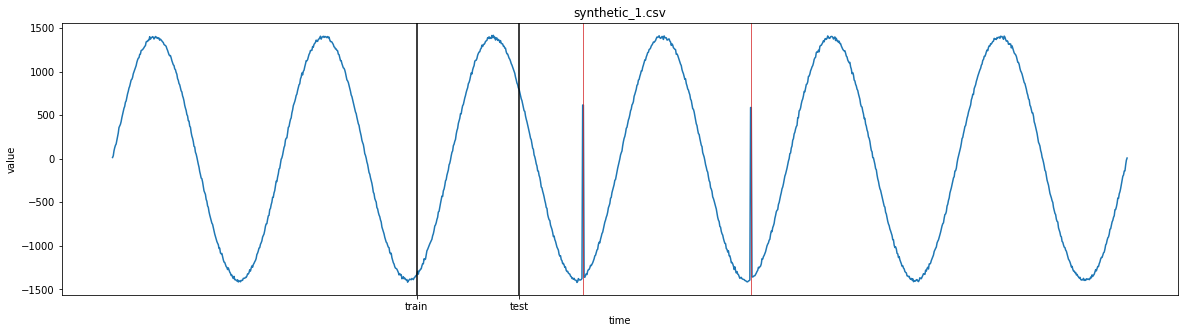

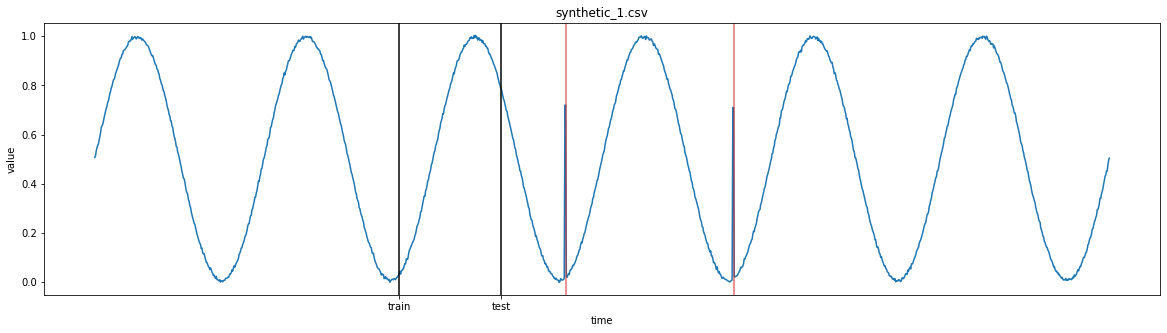

In [8]:
full_len, trn_len, dev_len, tst_len, full_loader, trn_loader, dev_loader, tst_loader = get_dataloader(args)

# Create a trainer object for training
trainer = Trainer(args, full_len, trn_len, dev_len, tst_len, full_loader, trn_loader, dev_loader, tst_loader)

# Train
# trainer output: best checkpoint, version(the order of executions)
best_result, version = trainer.fit()

# Test
# load the checkpoint to be tested
data_path = args.root_path + args.data_name
model_path = f'./saved_model/{args.experiment_name}/{data_path[3:-4]}/version-{version}/checkpoints/epoch-{best_result}.pt'
ckpt = torch.load(model_path)

# compute anomaly score, detect anomalies, compute performance measures, and plot the result
trainer.test(ckpt, version)